In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [5]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [6]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [7]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

### Training

In [8]:
from utils.distrib import color_smart_diff, color_smart_diff_outer
from scipy.spatial.distance import cdist

def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d


class DistFunctions:
    """ define all distance function """
    @classmethod
    def diff(cls, x1, x2, dist_name, pairwise):
        if dist_name == 'cos':
            return cls.cos_diff(x1, x2, pairwise)
        elif dist_name == 'rad':
            return cls.rad_diff(x1, x2, pairwise)
        elif dist_name == 'deg':
            return cls.deg_diff(x1, x2, pairwise)
        elif dist_name == 'euc':
            return cls.euclidean_diff(x1, x2, pairwise)
        else:
            raise NotImplementedError(f'Unknown distance {dist_name}')

    @classmethod
    def cos_diff(cls, x1, x2, pairwise):
        x1 = x1 / np.linalg.norm(x1, axis=-1, keepdims=True)
        x2 = x2 / np.linalg.norm(x2, axis=-1, keepdims=True)
        if pairwise:
            dists = cdist(x1, x2, metric='cosine')
        else:
            similarity = np.sum(x1 * x2, axis=-1)
            dists = 1 - similarity
        return dists
    
    @classmethod
    def euclidean_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = cdist(x1, x2, metric='euclidean')
        else:
            diffs = x1 - x2
            dists = np.linalg.norm(diffs, axis=-1)
        return dists
    
    @classmethod
    def deg_diff(cls, x1, x2, pairwise):
        if pairwise:
            assert len(x2.shape) == 1
            x1 = x1[..., np.newaxis]
            d1 = x1 - x2 # expand last dim
        else:
            d1 = x1 - x2 # elementwise

        # convert dists to degree dists
        deg_diffs = np.abs(deg_signed_diff(d1))
        return deg_diffs
    
    @classmethod
    def rad_diff(cls, x1, x2, pairwise):
        dists = np.abs(cls.deg_diff(x1, x2, pairwise))      
        dists = np.deg2rad(dists)
        return dists

In [9]:
from scipy.ndimage import zoom

class FeatureDowngrade:
    def __init__(self, params):
        self.params = params

    def get_converted_features(self, Xs):
        new_features = []
        # 0d
        if '0d' in self.params:
            d0_features = self.get_0d(Xs)
            new_features.append(d0_features)
        #1d
        if '1d' in self.params:
            d1_features = self.shrink_1d(Xs)
            new_features.append(d1_features)
        #2d
        if '2d' in self.params:
            d2_features = self.shrink_2d(Xs)
            new_features.append(d2_features)
        new_features = np.concatenate(new_features, axis=-1)
        return new_features

    def get_0d(self, Xs):
        d0_params = self.params['0d']
        d0_features = Xs[..., d0_params['old']]
        return d0_features

    def shrink_1d(self, Xs):
        d1_params = self.params['1d']
        d1_old = Xs[..., d1_params['old']]
        d1_new = d1_old.copy()
        d1_shrink_ratio = d1_params.get('zoom_ratio', None)
        if d1_shrink_ratio is None:
            return d1_new
        else:
            d1_shrink_ratio_list = np.ones(len(d1_new.shape))
            d1_shrink_ratio_list[-1] = d1_shrink_ratio
            d1_new = zoom(d1_new, 
                zoom=d1_shrink_ratio_list, mode='wrap', order=1)
            return d1_new

    def shrink_2d(self, Xs):
        d2_params = self.params['2d']
        d2_old = Xs[..., d2_params['old']]
        d2_new = d2_old.copy()
        d2_shrink_ratio = d2_params.get('zoom_ratio', None)
        if d2_shrink_ratio is None:
            return d2_new
        else:
            # reformat d2
            H, W = d2_params['H'], d2_params['W']
            original_shape = d2_new.shape
            new_shape = (*original_shape[:-1], H, W)
            d2_new = d2_new.reshape(new_shape)

            # zoom
            d2_shrink_ratio_list = np.ones(len(d2_new.shape))
            d2_shrink_ratio_list[-2:] = d2_shrink_ratio
            d2_new = zoom(d2_new, zoom=d2_shrink_ratio_list, mode='wrap', order=1)

            # flatten
            new_shape = (*original_shape[:-1], d2_new.shape[-2] * d2_new.shape[-1])
            d2_new = d2_new.reshape(new_shape)

            return d2_new

class ForwardModel:
    def __init__(self, feature_conversion_params, n_channels):
        self.feature_conversion = FeatureDowngrade(feature_conversion_params)
        # create channels and channel centers
        self.n_channels = n_channels
        self.channel_bins = np.linspace(0, 180, n_channels+1)
        self.channel_cenetrs = (self.channel_bins[1:] + self.channel_bins[:-1]) / 2

    def raw_ys_to_channel_weights(self, ys, sharpness):
        # convert first to radian differece
        rad_diffs = DistFunctions.diff(
            ys, self.channel_cenetrs, 
            dist_name='rad', pairwise=True)
        # rad diffs to weights
        weights = np.exp(sharpness * np.cos(rad_diffs))
        # normalize
        weights = weights / np.sum(weights, axis=-1, keepdims=True)
        return weights

    def convert_xinputs(self, Xs):
        Xs = self.feature_conversion.get_converted_features(Xs)
        return Xs

    def get_channel_patterns(self, Xs, ys, item_weights, sharpness):
        # convert xs
        Xs = self.convert_xinputs(Xs)
        # get the channel weights
        ys = self.raw_ys_to_channel_weights(ys, sharpness)
        # get the total weights
        ys = item_weights[..., None] * ys
        ys = np.sum(ys, axis=-2) # across items
        ys = ys / np.sum(ys, axis=-1, keepdims=True) # normalize
        # least square
        C_hat = np.linalg.pinv(ys.T @ ys) @ ys.T @ Xs
        return Xs, ys, C_hat
        
    def find_best_y_transform(self, Xs, ys, item_weights, sharpness_range, x_dist_func, x_thresh):
        # find the best y transform
        best_sharpness = None
        best_loss = np.inf
        for sharpness in sharpness_range:
            Xs_test, ys_test, C_hat_test = self.get_channel_patterns(
                Xs, ys, item_weights, sharpness)
            Xs_pred = ys_test @ C_hat_test
            # first check if the range is ok
            x_outlier_ratio = np.mean((Xs_pred > x_thresh) | (Xs_pred < -x_thresh))
            loss = DistFunctions.diff(
                Xs_pred, Xs_test, x_dist_func, pairwise=False)
            loss = np.mean(loss)
            print(f'sharpness {sharpness:.2f} loss {loss:.6f} (invalid: {x_outlier_ratio:.2f})')
            if loss < best_loss:
                best_loss = loss
                best_sharpness = sharpness

        return best_sharpness, best_loss
    
    def predict(self, Xs, C_hat):
        Xs = self.convert_xinputs(Xs)
        ys = Xs @ C_hat.T @ np.linalg.pinv(C_hat @ C_hat.T)
        return Xs, ys

### Get Xs and Ys

### Find best sharpness value

In [10]:
d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION = {
    '0d': {
        'old': np.array([0, 1]),
    },
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

In [11]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [12]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

#### ISI phase best sharpness

In [13]:
def reformat_all_loaded(phase, stim_names, cond_lmb):
    all_xs, all_ys, all_dfs, all_tags = [], [], [], []
    for subj in all_subjs:
        features, behavior_df = load_subject_time_feature(subj, phase)
        mask = cond_lmb(behavior_df)
        features = features[mask]
        behavior_df = behavior_df[mask]
        behavior_ys = behavior_df[stim_names].values
        all_xs.append(features)
        all_ys.append(behavior_ys)
        all_dfs.append(behavior_df)
        all_tags.append([subj] * len(features))
    # compute the default weights
    all_xs = np.concatenate(all_xs, axis=0)
    all_ys = np.concatenate(all_ys, axis=0)
    all_tags = np.concatenate(all_tags, axis=0)
    all_dfs = pd.concat(all_dfs, axis=0, ignore_index=True)
    return all_xs, all_ys, all_dfs, all_tags

In [14]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [15]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=18)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

sharpness 0.50 loss 7.350904 (invalid: 0.00)
sharpness 1.00 loss 7.350913 (invalid: 0.00)
sharpness 2.00 loss 7.350817 (invalid: 0.00)
sharpness 4.00 loss 7.350714 (invalid: 0.00)
sharpness 6.00 loss 7.350879 (invalid: 0.00)
sharpness 8.00 loss 7.350660 (invalid: 0.00)
sharpness 10.00 loss 7.350468 (invalid: 0.00)
sharpness 12.00 loss 7.350642 (invalid: 0.00)
sharpness 14.00 loss 7.350641 (invalid: 0.00)
sharpness 16.00 loss 7.350644 (invalid: 0.00)
sharpness 20.00 loss 7.350651 (invalid: 0.00)
sharpness 30.00 loss 7.350675 (invalid: 0.00)
sharpness 40.00 loss 7.350693 (invalid: 0.00)


In [16]:
ISI_best_sharpness

10

#### Delay phase best sharpness

In [17]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, _, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [18]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=18)
item_weights = np.ones_like(delay_ys) * 0.5 # two items
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

sharpness 0.50 loss 7.190600 (invalid: 0.00)
sharpness 1.00 loss 7.190586 (invalid: 0.00)
sharpness 2.00 loss 7.190839 (invalid: 0.00)
sharpness 4.00 loss 7.190722 (invalid: 0.00)
sharpness 6.00 loss 7.190328 (invalid: 0.00)
sharpness 8.00 loss 7.190577 (invalid: 0.00)
sharpness 10.00 loss 7.190869 (invalid: 0.00)
sharpness 12.00 loss 7.190795 (invalid: 0.00)
sharpness 14.00 loss 7.190783 (invalid: 0.00)
sharpness 16.00 loss 7.190780 (invalid: 0.00)
sharpness 20.00 loss 7.190773 (invalid: 0.00)
sharpness 30.00 loss 7.190746 (invalid: 0.00)
sharpness 40.00 loss 7.190715 (invalid: 0.00)


In [19]:
delay_best_sharpness

6

### Convert training data into patterns

In [20]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': 18,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [21]:
from tqdm import tqdm

def across_subj_cross_phase_iterator(
        phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb, item_weights_lmb,
        kfold):
    
    # load all data for all subjects
    xs1, ys1, df1, tags1 = reformat_all_loaded(
        phase1, phase1_stim_types, phase1_lmb)
    xs2, ys2, df2, tags2 = reformat_all_loaded(
        phase2, phase2_stim_types, phase2_lmb)

    # cv
    all_subj_ids = list(set(tags1))
    np.random.shuffle(all_subj_ids)
    heldout_subj_ids = np.array_split(all_subj_ids, kfold)
    heldout_subj_ids = [set(subj_ids) for subj_ids in heldout_subj_ids]

    for i in tqdm(list(range(kfold))):
        # train and test mask
        train_heldout_mask = np.array(
            [s in heldout_subj_ids[i] for s in tags1])
        train_mask = ~train_heldout_mask
        train_subj_ids = set(tags1[train_mask])
        test_heldout_mask = np.array(
            [s in train_subj_ids for s in tags2])
        test_mask = ~test_heldout_mask
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        fold_train_df, fold_test_df = df1[train_mask], df2[test_mask]
        # yield data
        yield {
            'xs1': fold_train_xs,
            'ys1': fold_train_ys,
            'df1': fold_train_df,
            'xs2': fold_test_xs,
            'ys2': fold_test_ys,
            'df2': fold_test_df,
            'item_weights': item_weights_lmb(fold_train_df),
        }

In [22]:
def train_test_invert_encoding(
        model_params, xs1, xs2, ys1, ys2, df1, df2,
        item_weights=None):
    # get the weight of items
    if item_weights is None:
        item_weights = ~(np.isnan(ys1))
        item_weights = item_weights / np.sum(
            item_weights, axis=-1, keepdims=True)
        
    model = ForwardModel(**model_params['init'])
    sharpness = model_params['forward']['sharpness']
    # get pattern
    xs1_trans, ys1_trans, patterns = model.get_channel_patterns(
        xs1, ys1, item_weights, sharpness)
    # predict
    xs2_trans, ys_pred = model.predict(xs2, patterns)
    # also get the converted ys2
    ys2_trans = model.raw_ys_to_channel_weights(ys2, sharpness)
    # collect results
    results = {
        'list': {
            # 'train_xs': xs1,
            # 'train_xs_converted': xs1_trans,
            # 'train_ys': ys1,
            # 'train_ys_converted': ys1_trans,
            'test_xs': xs2,
            'test_xs_converted': xs2_trans,
            'test_ys': ys2,
            'test_ys_converted': ys2_trans,
            'preds': ys_pred,
        },
        'df': {
            # 'train_df': df1,
            'test_df': df2,
        },
        'np': {
            'pattern': patterns,
        }
        
    }
    return results

In [23]:
from tqdm import tqdm

def cv_train_test_invert_encoding(
        model_params, phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb,
        item_weights_lmb, kfold):
    results = []
    progress_bar = tqdm(total=kfold, desc="Processing")
    for data in across_subj_cross_phase_iterator(
            phase1, phase2, phase1_stim_types, phase2_stim_types,
            phase1_lmb, phase2_lmb, item_weights_lmb, kfold):
        result = train_test_invert_encoding(model_params, **data)
        results.append(result)
        progress_bar.update(1)

    collected = {}
    for k in results[0]['list']:
        collected[k] = np.concatenate(
            [r['list'][k] for r in results], axis=0)
    for k in results[0]['df']:
        collected[k] = pd.concat(
            [r['df'][k] for r in results], ignore_index=True)
    for k in results[0]['np']:
        collected[k] = [r['np'][k] for r in results]
        collected[k] = np.mean(collected[k], axis=0)
    return collected

## Check decoding quality over the whole delay

In [24]:
item_weights_lmb = lambda df: np.ones((len(df), 2)) * 0.5
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    valid_both_lmb, valid_both_lmb, 
    item_weights_lmb, n_subjects)

Processing: 100%|██████████| 33/33 [00:08<00:00,  3.68it/s]


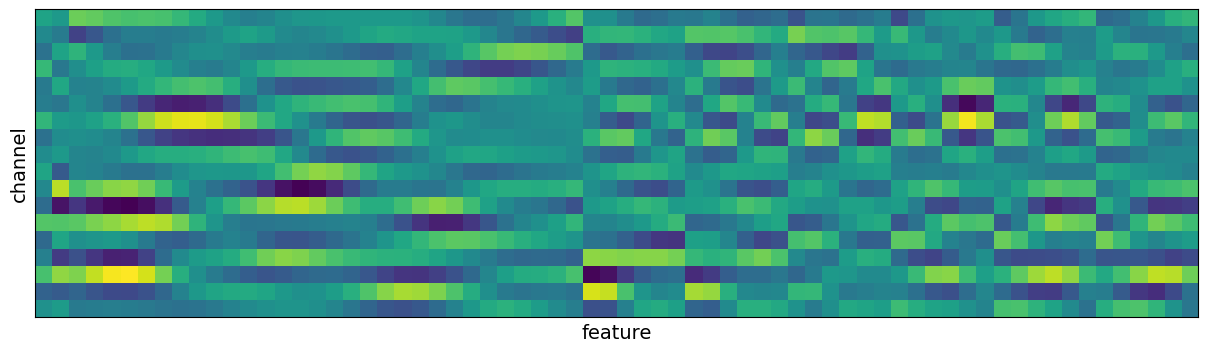

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(25, 4))
ax.imshow(full_delay_phase_results['pattern'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('feature', fontsize=14)
ax.set_ylabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_channel_pattern.png')
plt.savefig(plot_path)

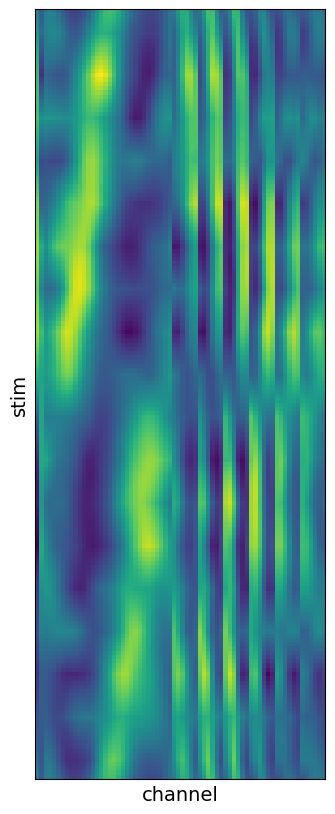

In [26]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])
delay_sharpness = DEFAULT_FORWARD_MODEL_PARAMS['forward']['sharpness']

channel_weight_projection = delay_model.raw_ys_to_channel_weights(
    np.arange(180), delay_sharpness)
full_patterns = channel_weight_projection @ full_delay_phase_results['pattern'] 

fig, ax = plt.subplots(1, figsize=(15, 10))
ax.imshow(full_patterns)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('stim', fontsize=14)
ax.set_xlabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern.png')
plt.savefig(plot_path)

### center all encoded

#### convert channel weights to (distribution of) stimuli

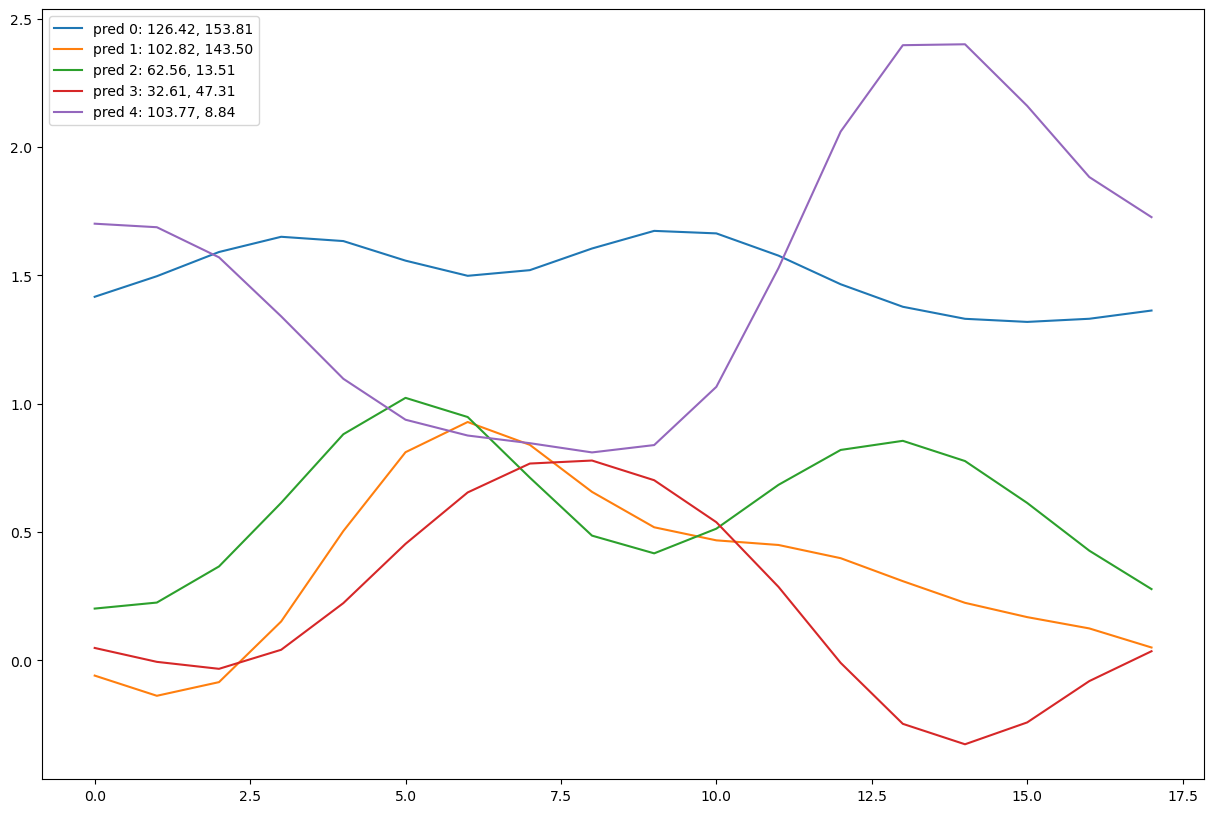

In [27]:
fig, ax = plt.subplots(1, figsize=(15, 10))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = full_delay_phase_results['preds'][i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

In [28]:
def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    thresh = 4 # too large or small offset is hard to interpret
    channel_weights = np.clip(channel_weights, -thresh, thresh)
    # channel_weights = np.exp(channel_weights / thresh)
    channel_weights = channel_weights - np.min(
        channel_weights, axis=-1, keepdims=True) + 1e-4

    default_degs = np.arange(180)
    projection = model.raw_ys_to_channel_weights(
        default_degs, sharpness)
    pdistrib = channel_weights @ projection.T

    # now make them a distribution
    distrib = pdistrib / np.sum(pdistrib, axis=-1, keepdims=True)

    return distrib
    

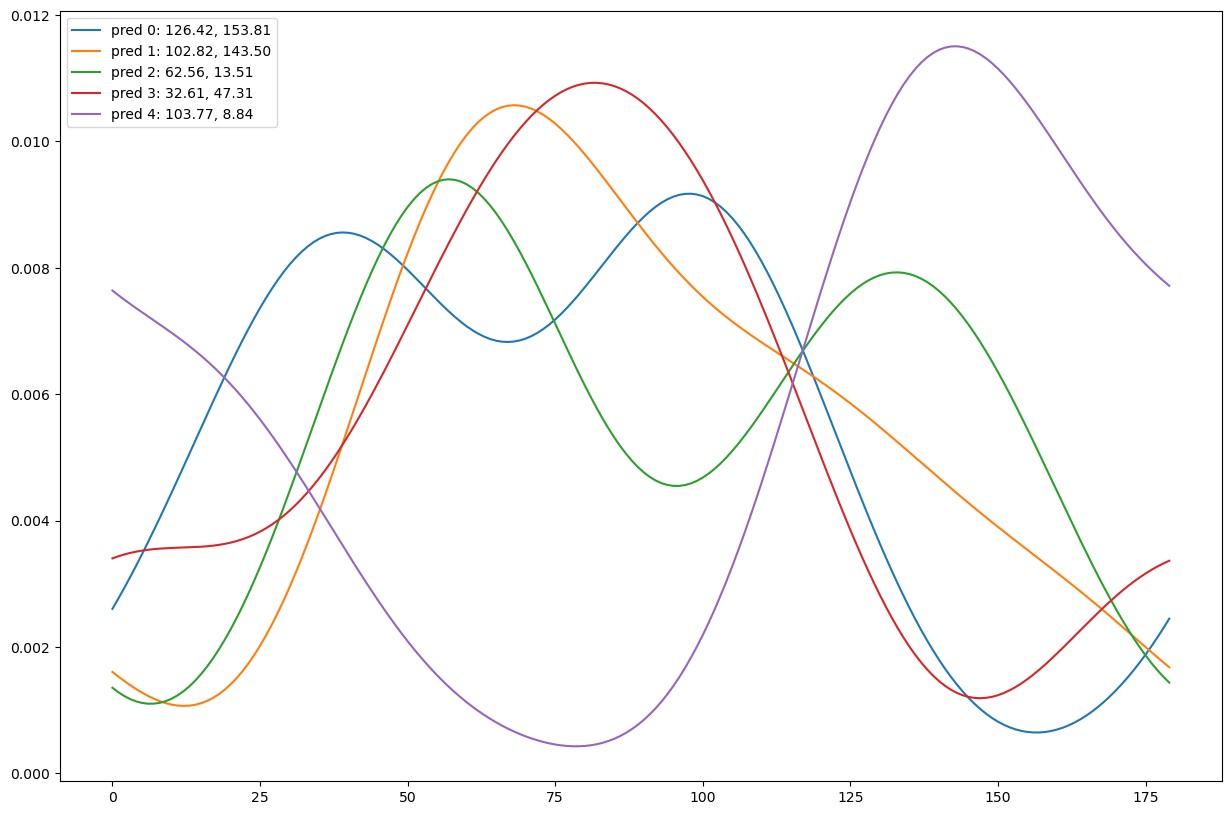

In [29]:
example_converted = channel_weights_to_pseudo_distrib(
    full_delay_phase_results['preds'], delay_model, 
    sharpness=20)
fig, ax = plt.subplots(1, figsize=(15, 10))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = example_converted[i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

#### flip and adjust the distribution --> so it aligns with the target we are checking

In [30]:
def shift_align_distrib(distrib, targets, refs=None):
    # filter out nan
    valid_mask = ~(np.isnan(targets))
    default_results = np.zeros_like(distrib)
    if refs is not None:
        valid_mask = valid_mask & ~(np.isnan(refs))
    distrib = distrib[valid_mask]
    targets = targets[valid_mask]
    if refs is not None:
        refs = refs[valid_mask]
    default_results[~valid_mask] = np.nan

    # determine the new x for each distrib
    default_degs = np.arange(180)
    default_diffs = deg_signed_diff(
        np.subtract.outer(targets, default_degs))
    relative_xs = - default_diffs
    if refs is not None:
        sd_diffs = deg_signed_diff(refs-targets)
        flip_mask = sd_diffs < 0
        relative_xs[flip_mask] = - relative_xs[flip_mask]
    relative_xs = (relative_xs % 180).astype(int)
    # shift it: error = 0, 1, 89, 90, -89,...-1
    shifted = np.zeros_like(distrib)
    row_indices = np.arange(len(distrib))[:, np.newaxis]
    col_indices = np.arange(180)
    shifted[row_indices, relative_xs] = distrib[
        row_indices, col_indices]
    default_results[valid_mask] = shifted

    return default_results

In [31]:
def display_shifted_distrib(ax, distrib, mask=None, label=None, min_max_y=1.2e-2, has_ref=True):
    # filter out those too vague (likely large error)
    # print(f'kept: {np.mean(distrib.max(axis=-1) > min_max_y):.2f}')
    # distrib = distrib[distrib.max(axis=-1) > min_max_y]
    if mask is not None:
        distrib = distrib[mask]
    
    summed = np.mean(distrib, axis=0)
    summed_xs = deg_signed_diff(np.arange(180))
    summed_idx = np.argsort(summed_xs)
    summed = summed[summed_idx]
    summed_xs = summed_xs[summed_idx]

    ax.plot(summed_xs, summed, label=label)
    ax.axvline(0, color='red', linestyle='--')
    if has_ref:
        ax.set_xticks([-45, 45])
        ax.set_xticklabels([
            '<<away from previous resp<<', 
            '>>towards previous resp>>'], fontsize=14)
        ax.set_xlabel('error (corrected)', fontsize=14)
    else:
        ax.set_xlabel('error', fontsize=14)
    ax.set_ylabel('probability', fontsize=14)
    ax.axhline(1/180, color='red', linestyle='--')
    ax.set_ylim([0.005, 0.0062])

#### Quantify the bias (using Fischer2024 method)

In [32]:
def compute_accuracy(distrib, T=180):
    # 0 --> err = 0
    # 0.5 --> max err
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.cos(np.deg2rad(errs))
    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)
    acc = np.sum(distrib_vec * baseline_vec, axis=-1)
    return acc

def compute_bias(distrib, T=180, err_thresh=None):
    # 0 --> no bias
    # 0.25 --> most positive bias
    # 0.5 --> neutral?
    # 0.75 --> most negative bias
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.sin(np.deg2rad(errs))
    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)

    # error filtering
    total_weights = np.linalg.norm(baseline_vec)
    if err_thresh is None:
        err_thresh = 180
    mask = np.abs(errs) <= (err_thresh * 360 / T)
    distrib_vec = distrib_vec[mask]
    baseline_vec = baseline_vec[mask]
    kept_weights = np.linalg.norm(baseline_vec)

    ratio = total_weights / kept_weights
    bias = np.sum(distrib_vec * baseline_vec, axis=-1) * ratio
    return bias

In [33]:
stat_func_mapping = {
    'accuracy': compute_accuracy,
    'bias': compute_bias,
}

def subjlevel_bias_stats(pred_distrib, df, cond_lmb, stat_type):
    if cond_lmb is not None:
        valid_mask = cond_lmb(df)
        pred_distrib = pred_distrib[valid_mask]
        df = df[valid_mask]
    subj_stats = []
    for subj in all_subjs:
        subj_mask = df['participant'] == int(subj)
        subj_bias = np.nan
        if np.sum(subj_mask) > 0:
            subj_distrib = pred_distrib[subj_mask]
            subj_distrib = np.mean(subj_distrib, axis=0)
            subj_bias = stat_func_mapping[stat_type](subj_distrib)
        subj_stats.append(subj_bias)
    subj_stats = np.array(subj_stats)
    return subj_stats

#### Combine visualization

In [34]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)
has_valid_prev_mask = has_valid_prev_lmb(full_delay_phase_results['test_df'])

In [35]:
def display_stats_and_distrib(ax, results, stats_type, 
        common_lmb=None, condition_lmbs={}):
    y_pred_distrib = channel_weights_to_pseudo_distrib(
        results['preds'], delay_model, sharpness=20)
    y_df = results['test_df']
    ys = results['test_ys']
    if common_lmb is not None:
        valid_mask = common_lmb(y_df)
        y_df = y_df[valid_mask]
        y_pred_distrib = y_pred_distrib[valid_mask]
        ys = ys[valid_mask]

    # compute distribs
    y_distribs_results = {}
    refs = y_df['prev_last_response'].values if stats_type == 'sd' else None
    for sid, stim_name in enumerate(['stim 1', 'stim 2']):
        y_distrib = shift_align_distrib(
            y_pred_distrib, ys[:, sid], refs=refs)
        y_distribs_results[stim_name] = y_distrib
    y_distribs_results['combined'] = np.mean([
        y_distribs_results['stim 1'], y_distribs_results['stim 2']], axis=0)
    
    for condname, cond_settings in condition_lmbs.items():
        cond_target = cond_settings['target']
        cond_lmb = cond_settings['lmb']
        cond_mask = None
        if cond_lmb is not None:
            cond_mask = cond_lmb(y_df)
        cond_distrib = y_distribs_results[cond_target]
        display_shifted_distrib(ax, cond_distrib, 
            mask=cond_mask, label=condname, has_ref=(refs is not None))
        # compute accuracy
        all_stats_names = []
        if stats_type == 'accuracy':
            all_stats_names = ['accuracy', 'bias']
        elif stats_type == 'sd':
            all_stats_names = ['bias']
        else:
            raise NotImplementedError(f'Unknown stats type {stats_type}')

        for stat_name in all_stats_names:
            stats = subjlevel_bias_stats(
                cond_distrib, y_df, cond_lmb, stat_name)
            stats = stats[~np.isnan(stats)]
            subj_mean = np.mean(stats)
            subj_sem = np.std(stats) / np.sqrt(len(stats))
            print(f'{condname} {stat_name}: {subj_mean:.3f} +- {subj_sem:.3f}')

    ax.legend()


### Firstly, check the combined

stim 1 accuracy: 0.490 +- 0.066
stim 1 bias: -0.029 +- 0.057
stim 2 accuracy: 0.314 +- 0.069
stim 2 bias: 0.018 +- 0.068
combined accuracy: 0.402 +- 0.057
combined bias: -0.006 +- 0.052


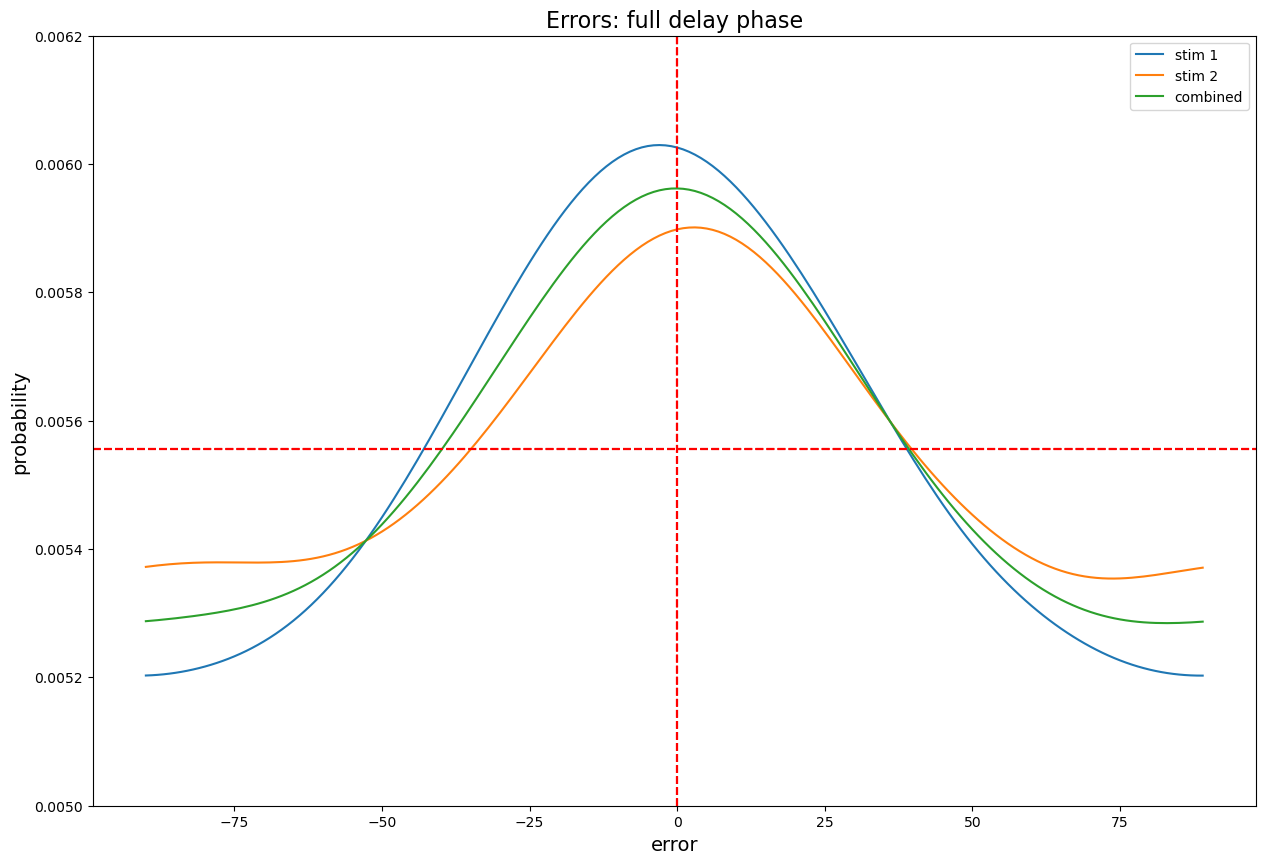

In [36]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings)
ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_acc.png')
plt.savefig(plot_path)


stim 1 bias: -0.087 +- 0.061
stim 2 bias: -0.024 +- 0.056
combined bias: -0.056 +- 0.049


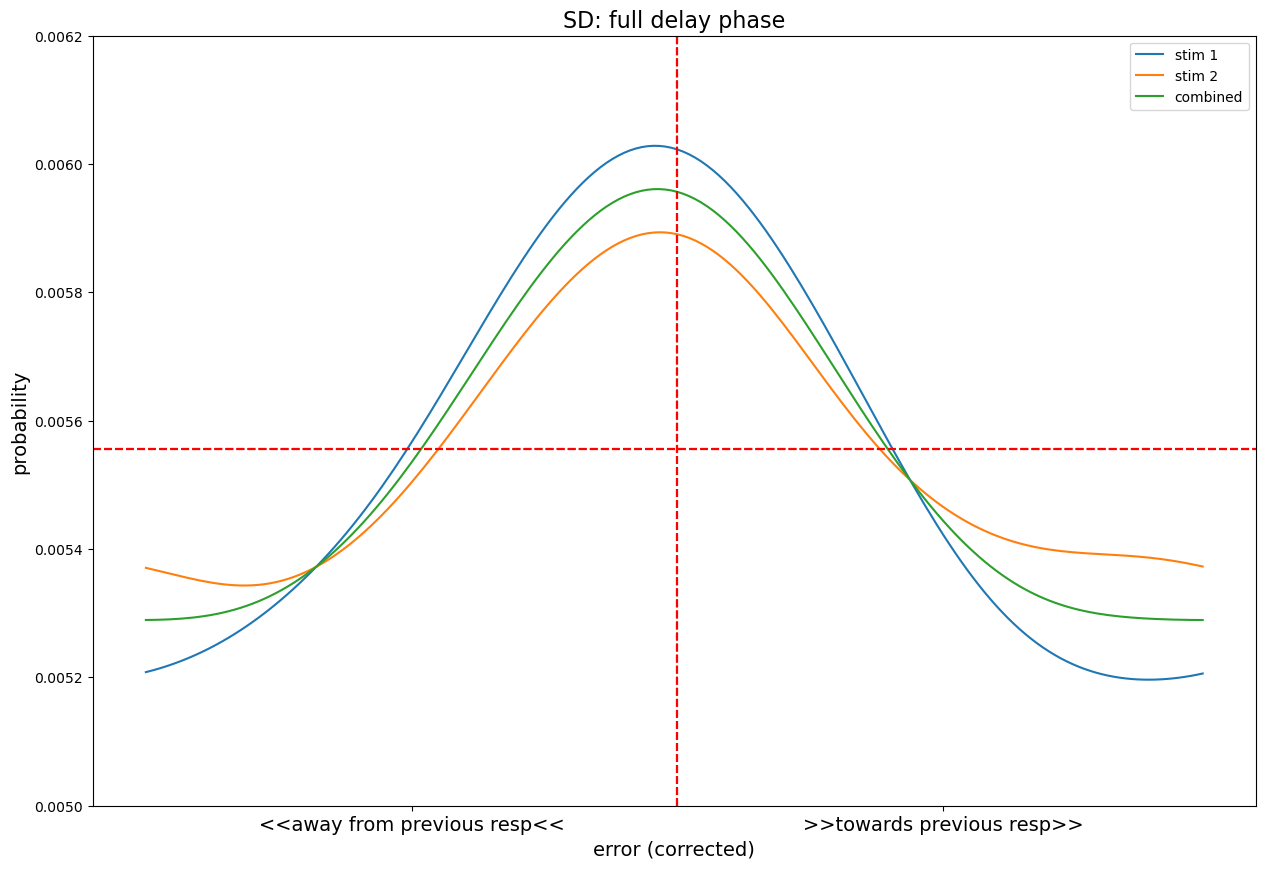

In [37]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('SD: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd.png')
plt.savefig(plot_path)


#### group by serial difference

In [38]:
serial_diffs_s1_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_1'].values))
serial_diffs_s2_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_2'].values)) 

stim 1 accuracy: 0.635 +- 0.106
stim 1 bias: 0.045 +- 0.104
stim 2 accuracy: 0.399 +- 0.100
stim 2 bias: -0.037 +- 0.094


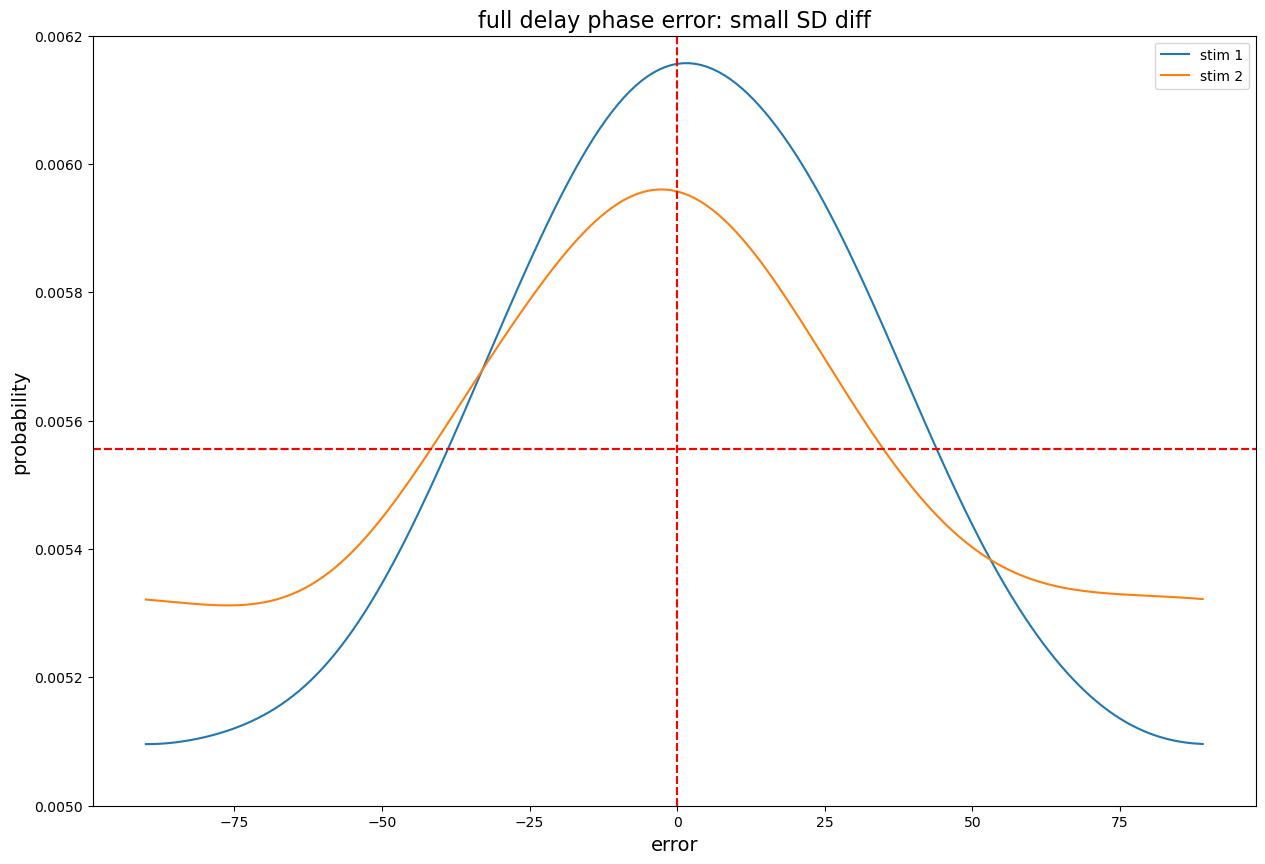

In [39]:
small_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) < 30)
small_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) < 30)

fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase error: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_acc.png')
plt.savefig(plot_path)

stim 1 bias: -0.062 +- 0.109
stim 2 bias: -0.021 +- 0.091


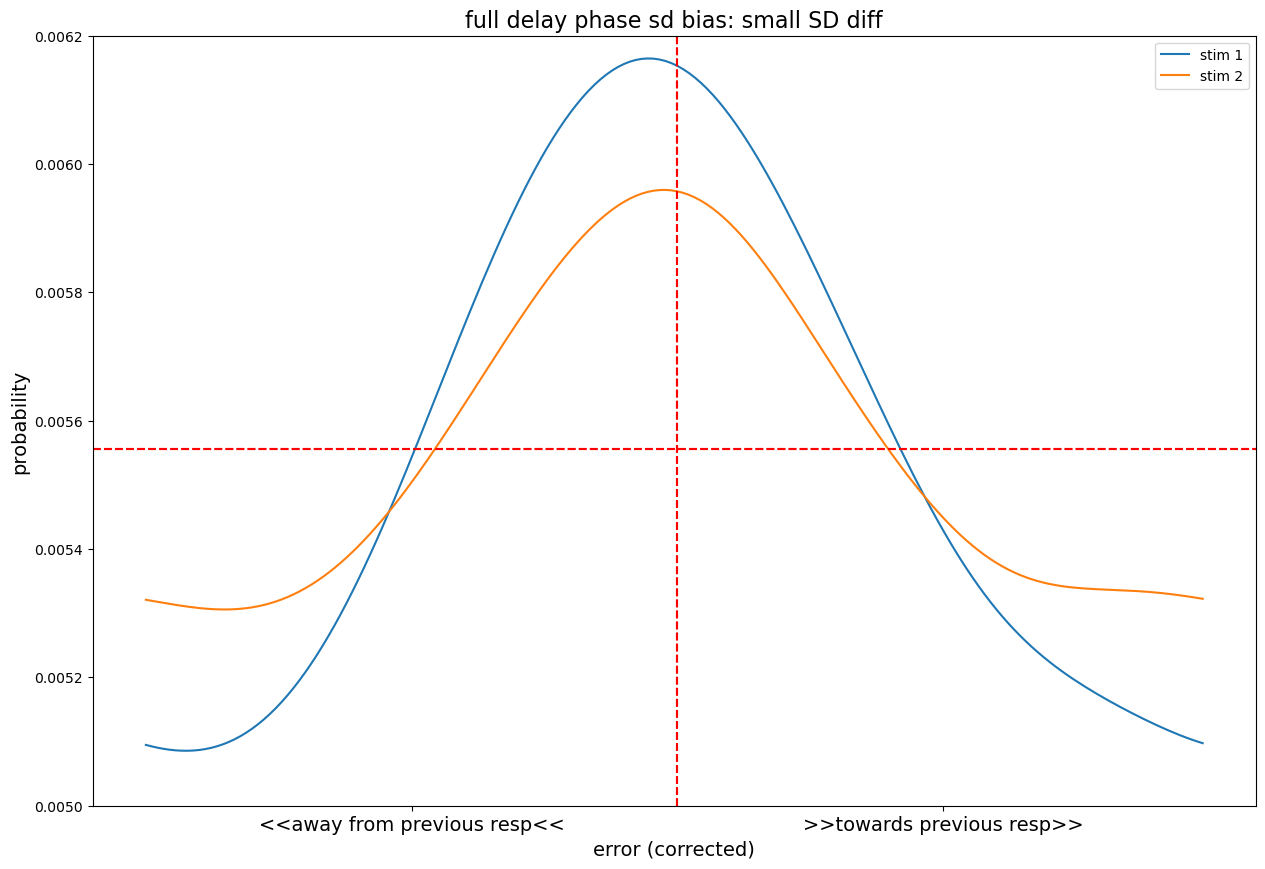

In [40]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase sd bias: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_sd.png')
plt.savefig(plot_path)

stim 1 accuracy: 0.461 +- 0.107
stim 1 bias: -0.008 +- 0.105
stim 2 accuracy: 0.434 +- 0.096
stim 2 bias: 0.106 +- 0.103


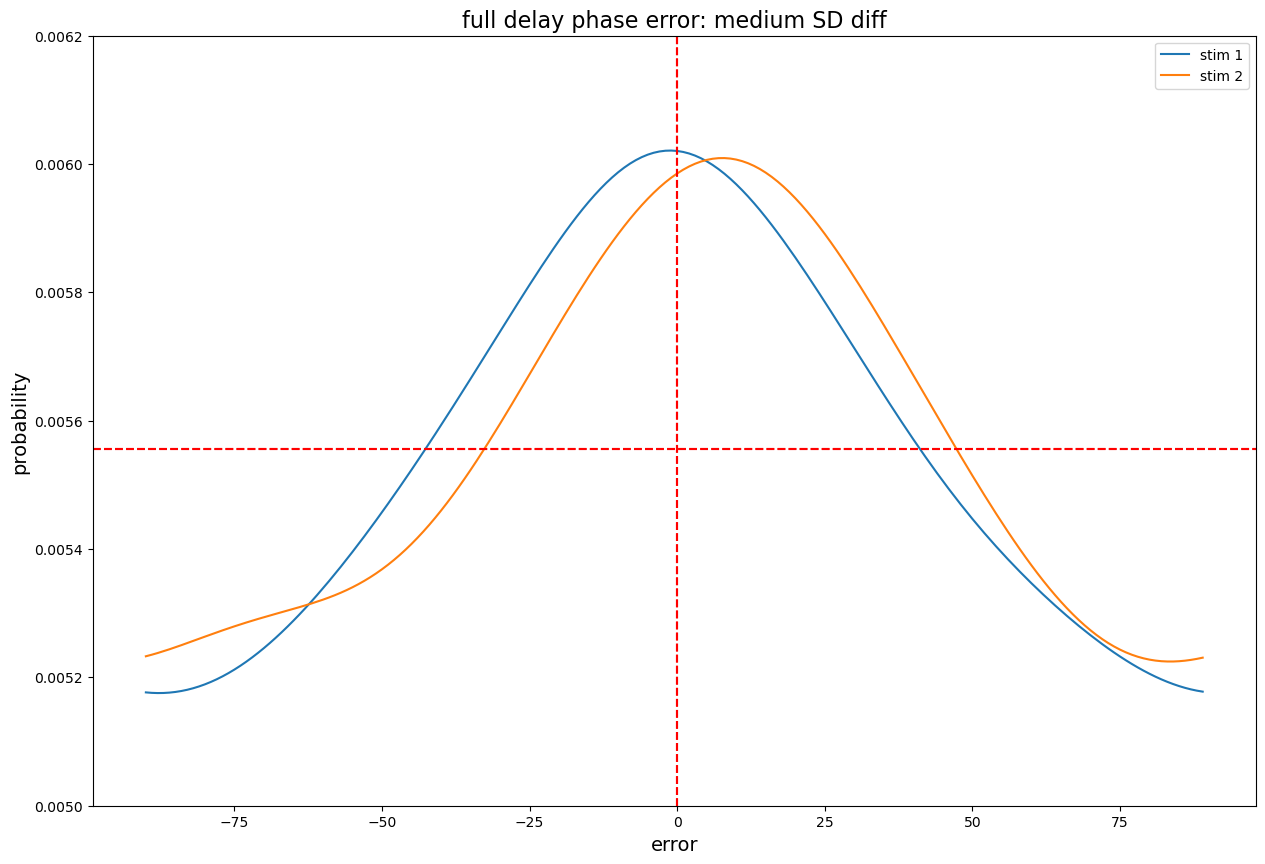

In [41]:
mid_sd1_lmb = lambda d: ((serial_diffs_s1_lmb(d) >= 30) & (serial_diffs_s1_lmb(d) < 60))
mid_sd2_lmb = lambda d: ((serial_diffs_s2_lmb(d) >= 30) & (serial_diffs_s2_lmb(d) < 60))

fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase error: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_acc.png')
plt.savefig(plot_path)

stim 1 bias: -0.104 +- 0.087
stim 2 bias: -0.013 +- 0.100


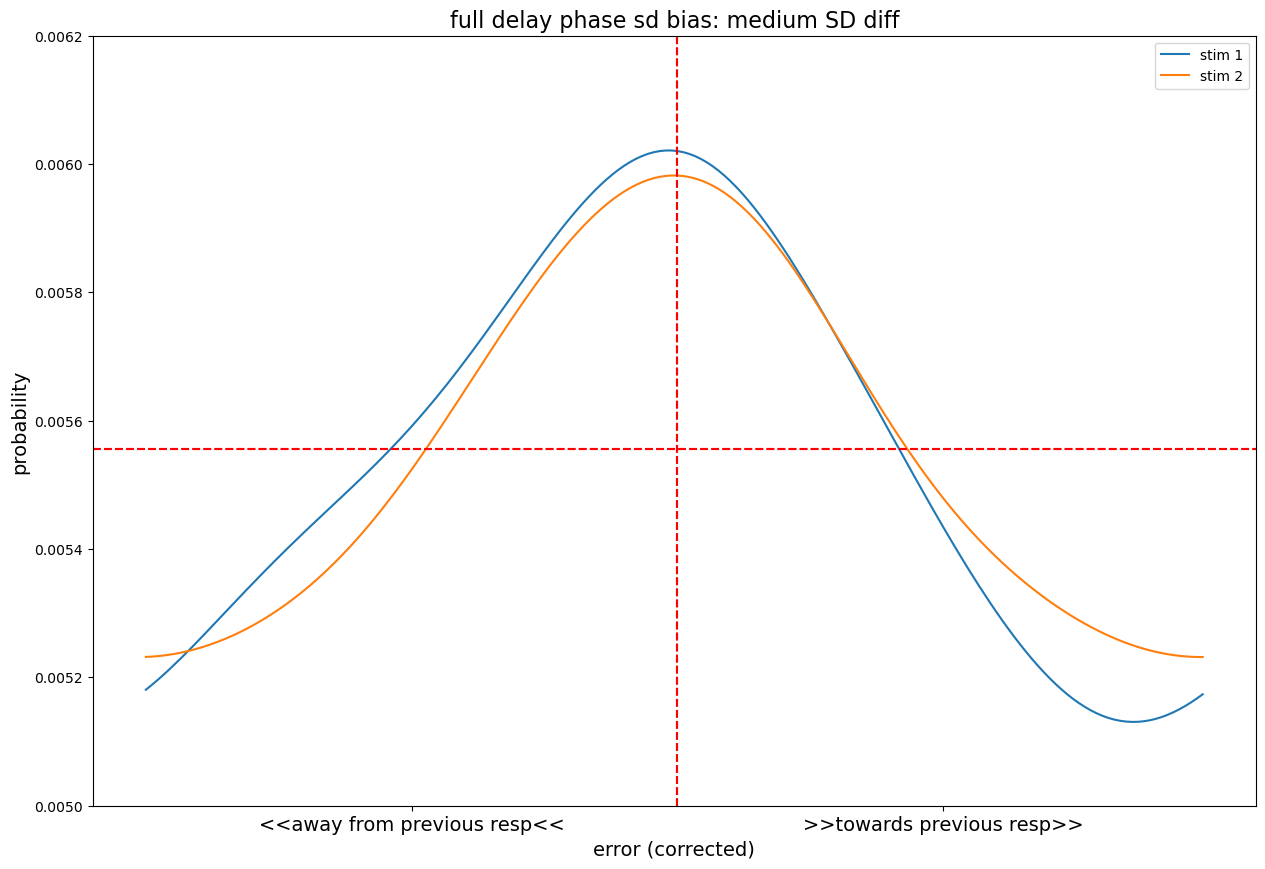

In [42]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase sd bias: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_sd.png')
plt.savefig(plot_path)

stim 1 accuracy: 0.355 +- 0.110
stim 1 bias: -0.045 +- 0.105
stim 2 accuracy: 0.116 +- 0.130
stim 2 bias: 0.031 +- 0.083


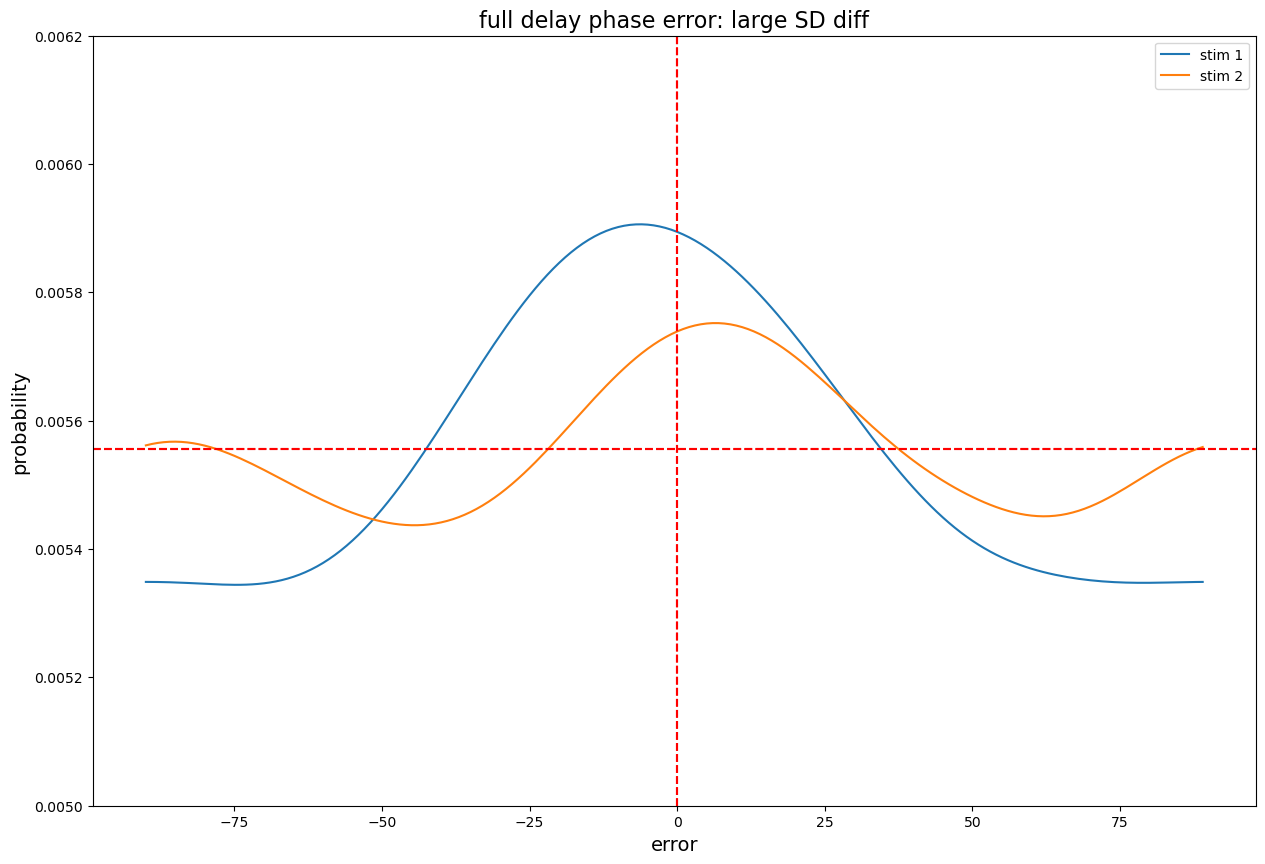

In [43]:
large_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) >= 60)
large_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) >= 60)

fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase error: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_acc.png')
plt.savefig(plot_path)

stim 1 bias: -0.082 +- 0.101
stim 2 bias: -0.010 +- 0.096


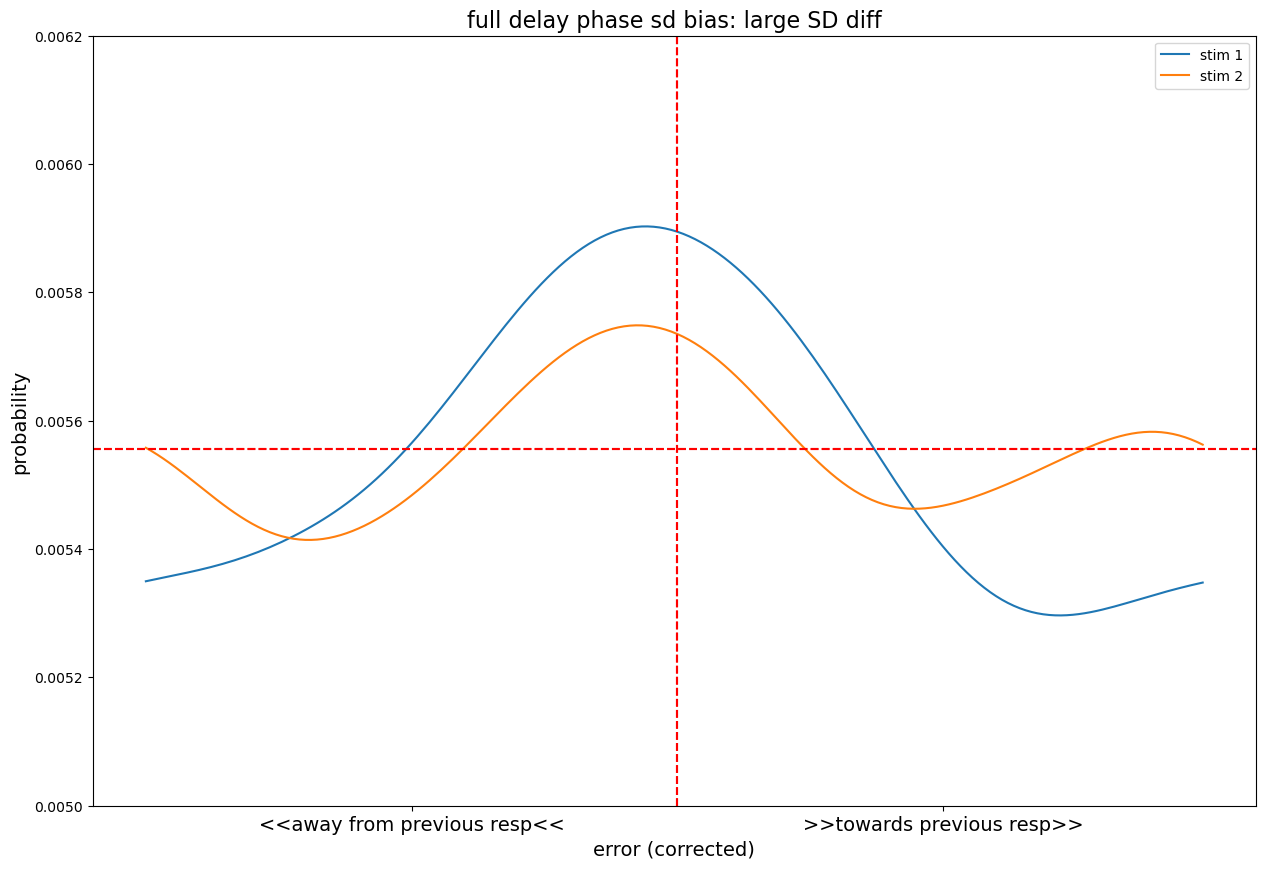

In [44]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase sd bias: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_sd.png')
plt.savefig(plot_path)

#### Compare different modes?

draw accuracy: 0.284 +- 0.068
draw bias: 0.055 +- 0.052
click accuracy: 0.522 +- 0.077
click bias: -0.063 +- 0.068


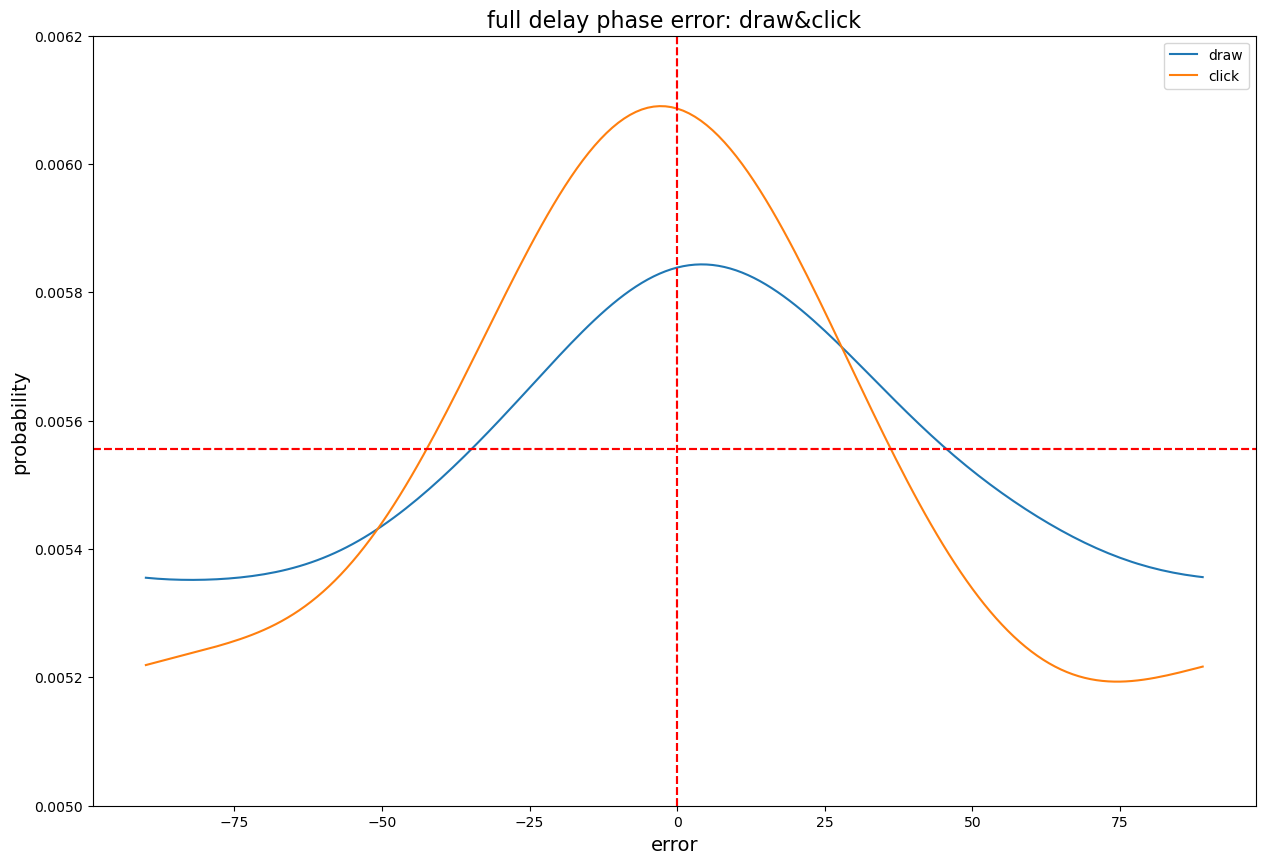

In [45]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings)
ax.set_title('full delay phase error: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_acc.png')
plt.savefig(plot_path)

draw bias: -0.049 +- 0.053
click bias: -0.062 +- 0.074


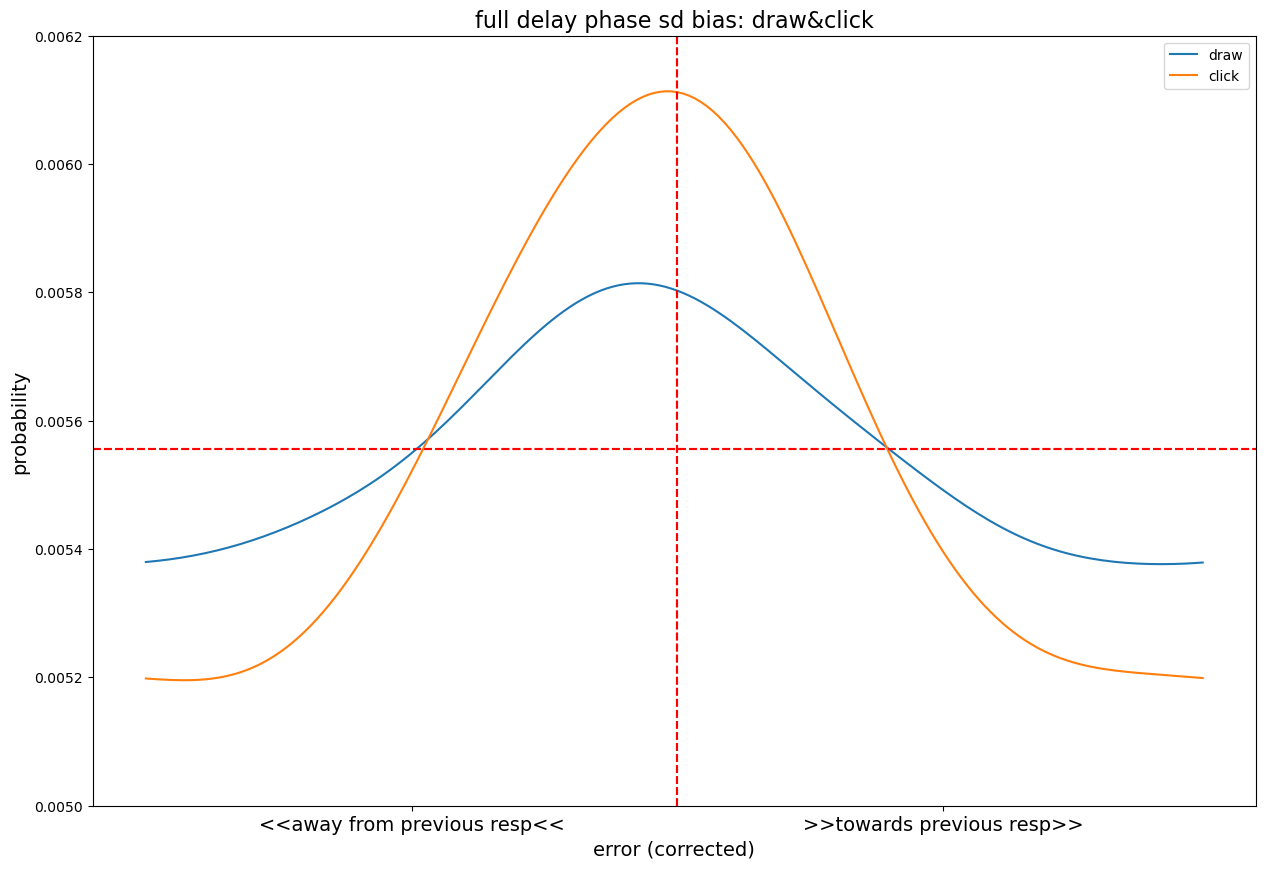

In [46]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(15, 10))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
ax.set_title('full delay phase sd bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sd.png')
plt.savefig(plot_path)

### Train & test across modes

In [47]:
draw_delay_lmb = lambda df: (
    valid_both_lmb(df) & (df['mode'] == 'draw').to_numpy())
click_delay_lmb = lambda df: (
    valid_both_lmb(df) & (df['mode'] == 'click').to_numpy())
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}

In [48]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: np.ones((len(df), 2)) * 0.5
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

Processing: 100%|██████████| 33/33 [00:07<00:00,  4.36it/s]


Trained on draw, tested on click


Processing: 100%|██████████| 33/33 [00:08<00:00,  3.81it/s]


Trained on click, tested on draw


Processing: 100%|██████████| 33/33 [00:07<00:00,  4.41it/s]


Trained on click, tested on click


Processing: 100%|██████████| 33/33 [00:07<00:00,  4.47it/s]


draw -> draw
stim 1 accuracy: 0.465 +- 0.079
stim 1 bias: 0.017 +- 0.061
stim 2 accuracy: 0.231 +- 0.104
stim 2 bias: 0.014 +- 0.088
combined accuracy: 0.349 +- 0.070
combined bias: 0.016 +- 0.055
draw -> click
stim 1 accuracy: 0.601 +- 0.087
stim 1 bias: -0.264 +- 0.111
stim 2 accuracy: 0.302 +- 0.091
stim 2 bias: -0.063 +- 0.076
combined accuracy: 0.453 +- 0.069
combined bias: -0.164 +- 0.072
click -> draw
stim 1 accuracy: 0.467 +- 0.090
stim 1 bias: 0.074 +- 0.069
stim 2 accuracy: 0.124 +- 0.063
stim 2 bias: 0.129 +- 0.096
combined accuracy: 0.296 +- 0.064
combined bias: 0.102 +- 0.064
click -> click
stim 1 accuracy: 0.534 +- 0.094
stim 1 bias: -0.040 +- 0.092
stim 2 accuracy: 0.390 +- 0.112
stim 2 bias: 0.080 +- 0.093
combined accuracy: 0.463 +- 0.076
combined bias: 0.019 +- 0.075


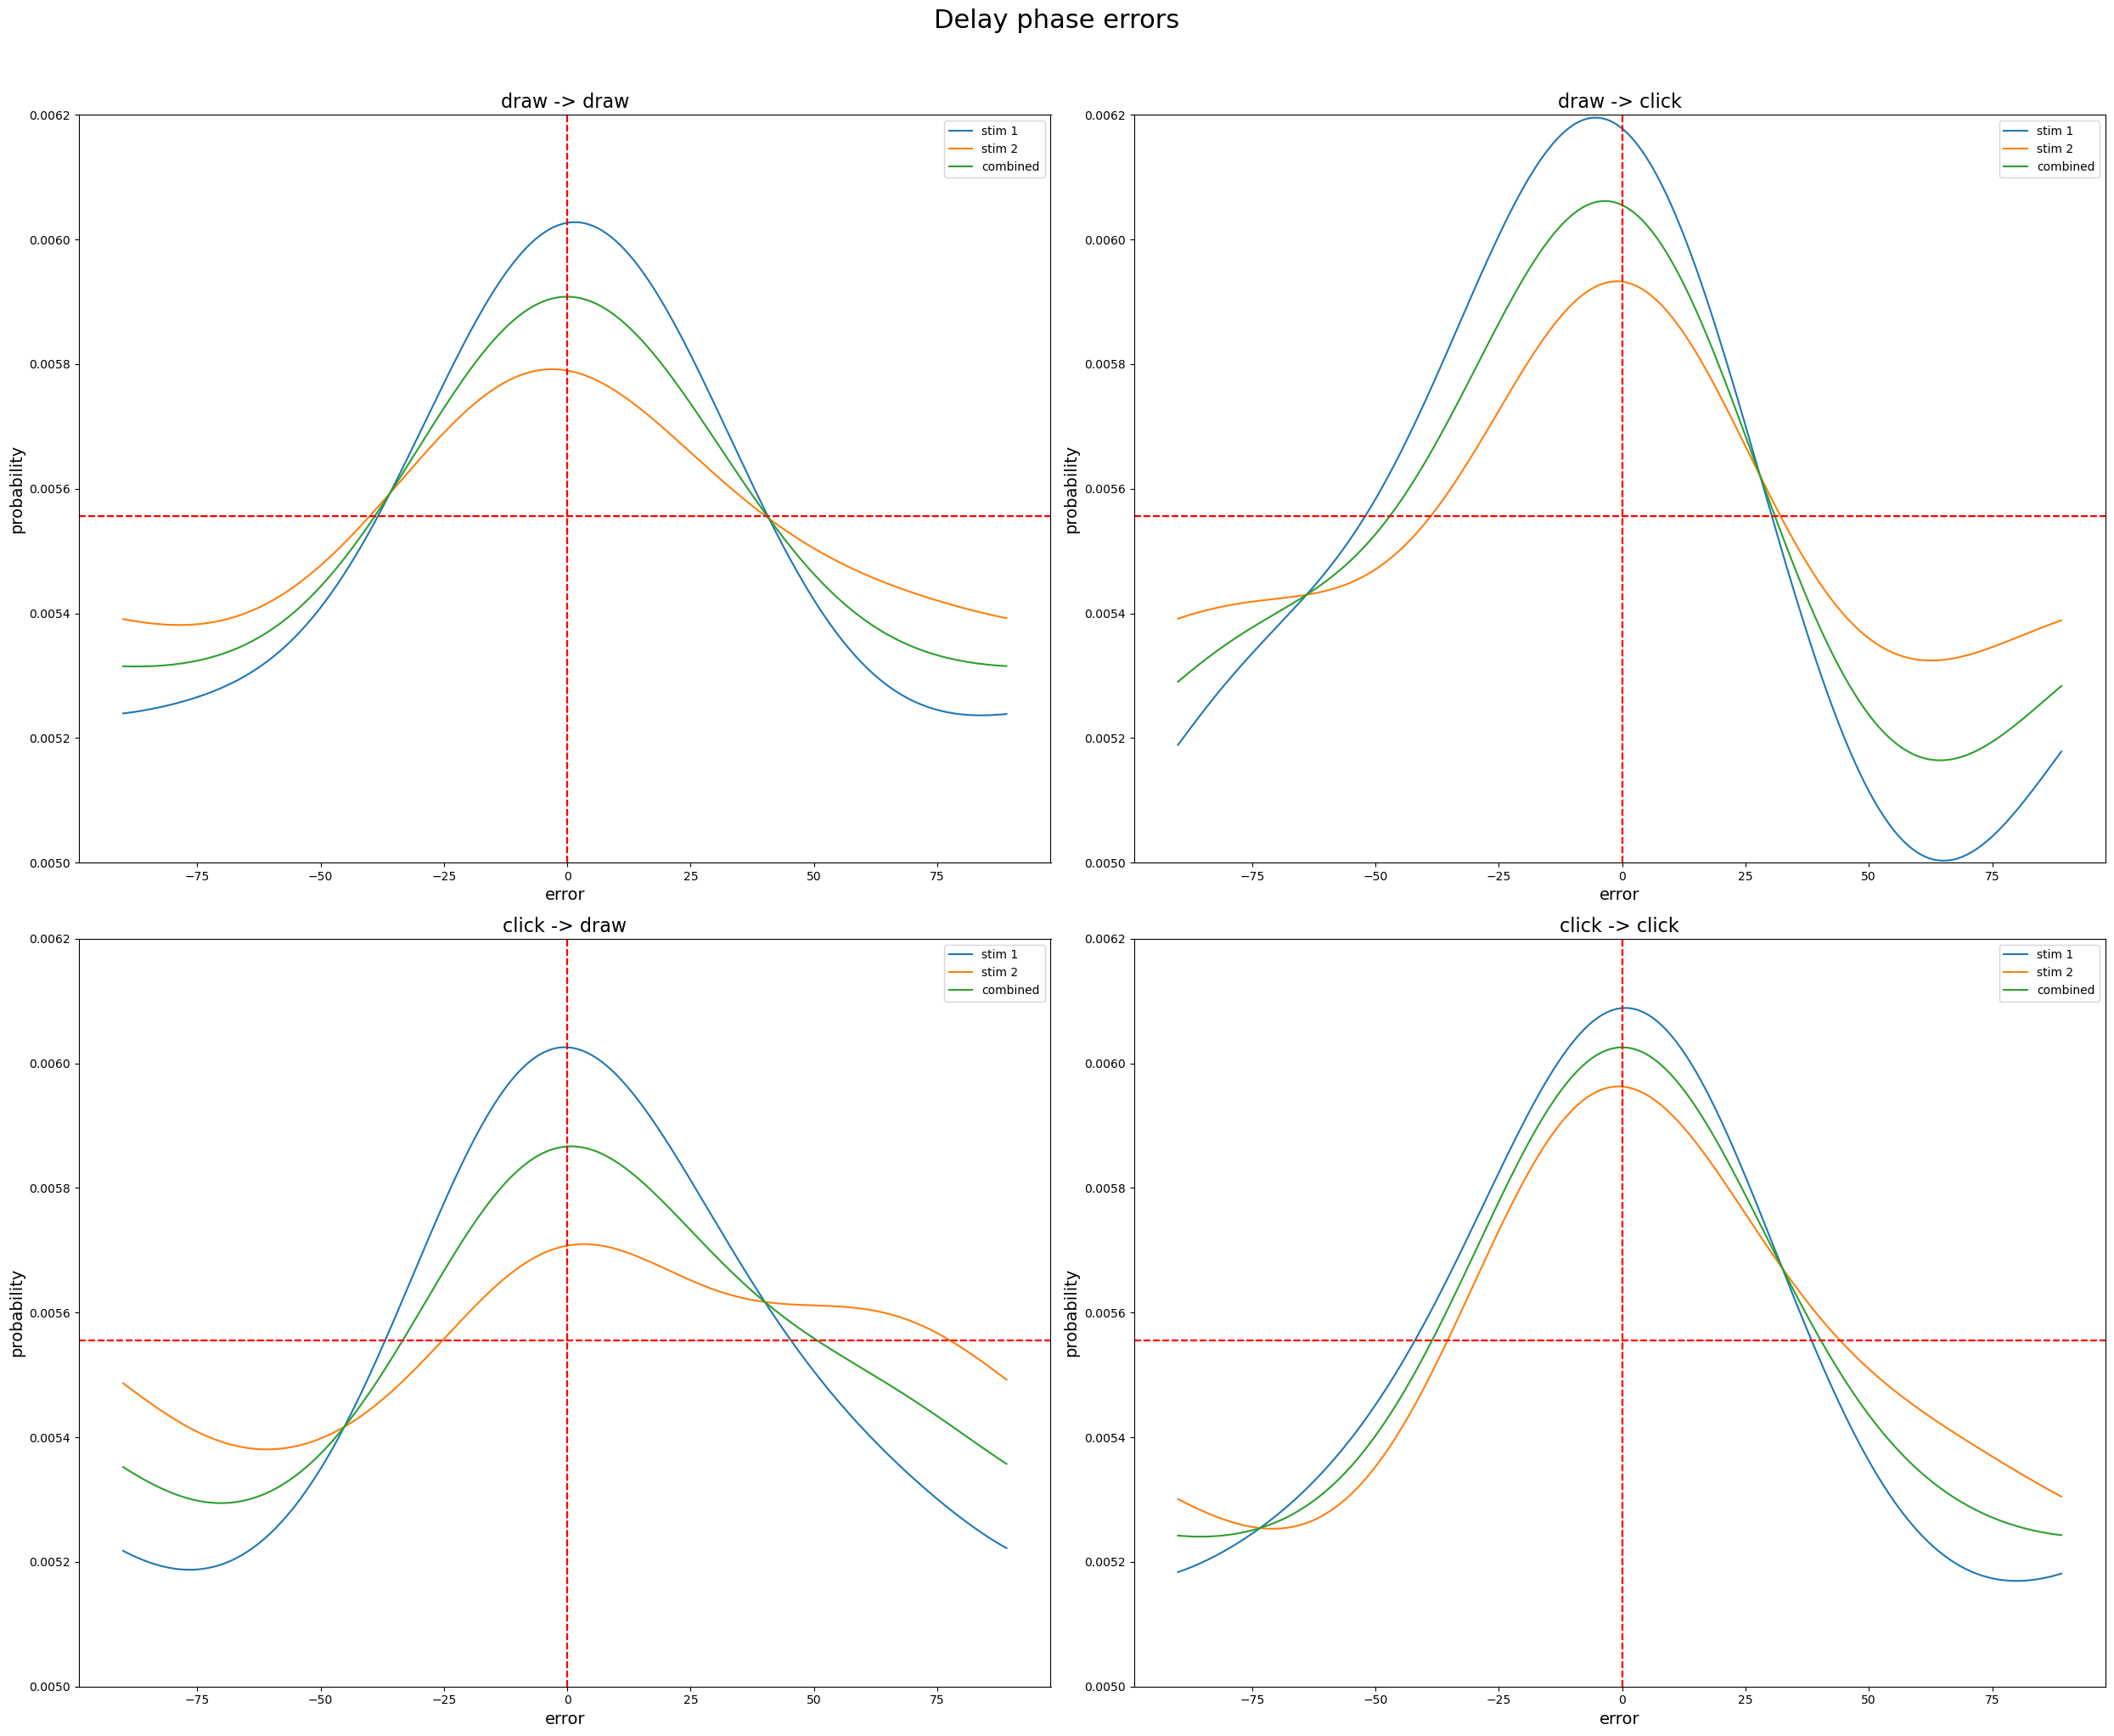

In [49]:
# also check serial bias
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, axs = plt.subplots(2, 2, figsize=(25, 20))
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        ax = axs[i, j]
        results = all_delay_across_modes[(train_mode, test_mode)]
        display_stats_and_distrib(ax,
            results,
            stats_type='accuracy', 
            common_lmb=None, condition_lmbs=plot_settings)
        ax.set_title(f'{train_mode} -> {test_mode}', fontsize=16)

plt.suptitle('Delay phase errors', fontsize=22, y=1.02)
plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_cross_modes_acc.png')
plt.savefig(plot_path)

draw -> draw
stim 1 bias: 0.026 +- 0.079
stim 2 bias: 0.005 +- 0.087
combined bias: 0.015 +- 0.074
draw -> click
stim 1 bias: -0.001 +- 0.082
stim 2 bias: 0.029 +- 0.082
combined bias: 0.014 +- 0.072
click -> draw
stim 1 bias: -0.019 +- 0.077
stim 2 bias: 0.129 +- 0.079
combined bias: 0.055 +- 0.064
click -> click
stim 1 bias: 0.011 +- 0.069
stim 2 bias: 0.066 +- 0.091
combined bias: 0.039 +- 0.063


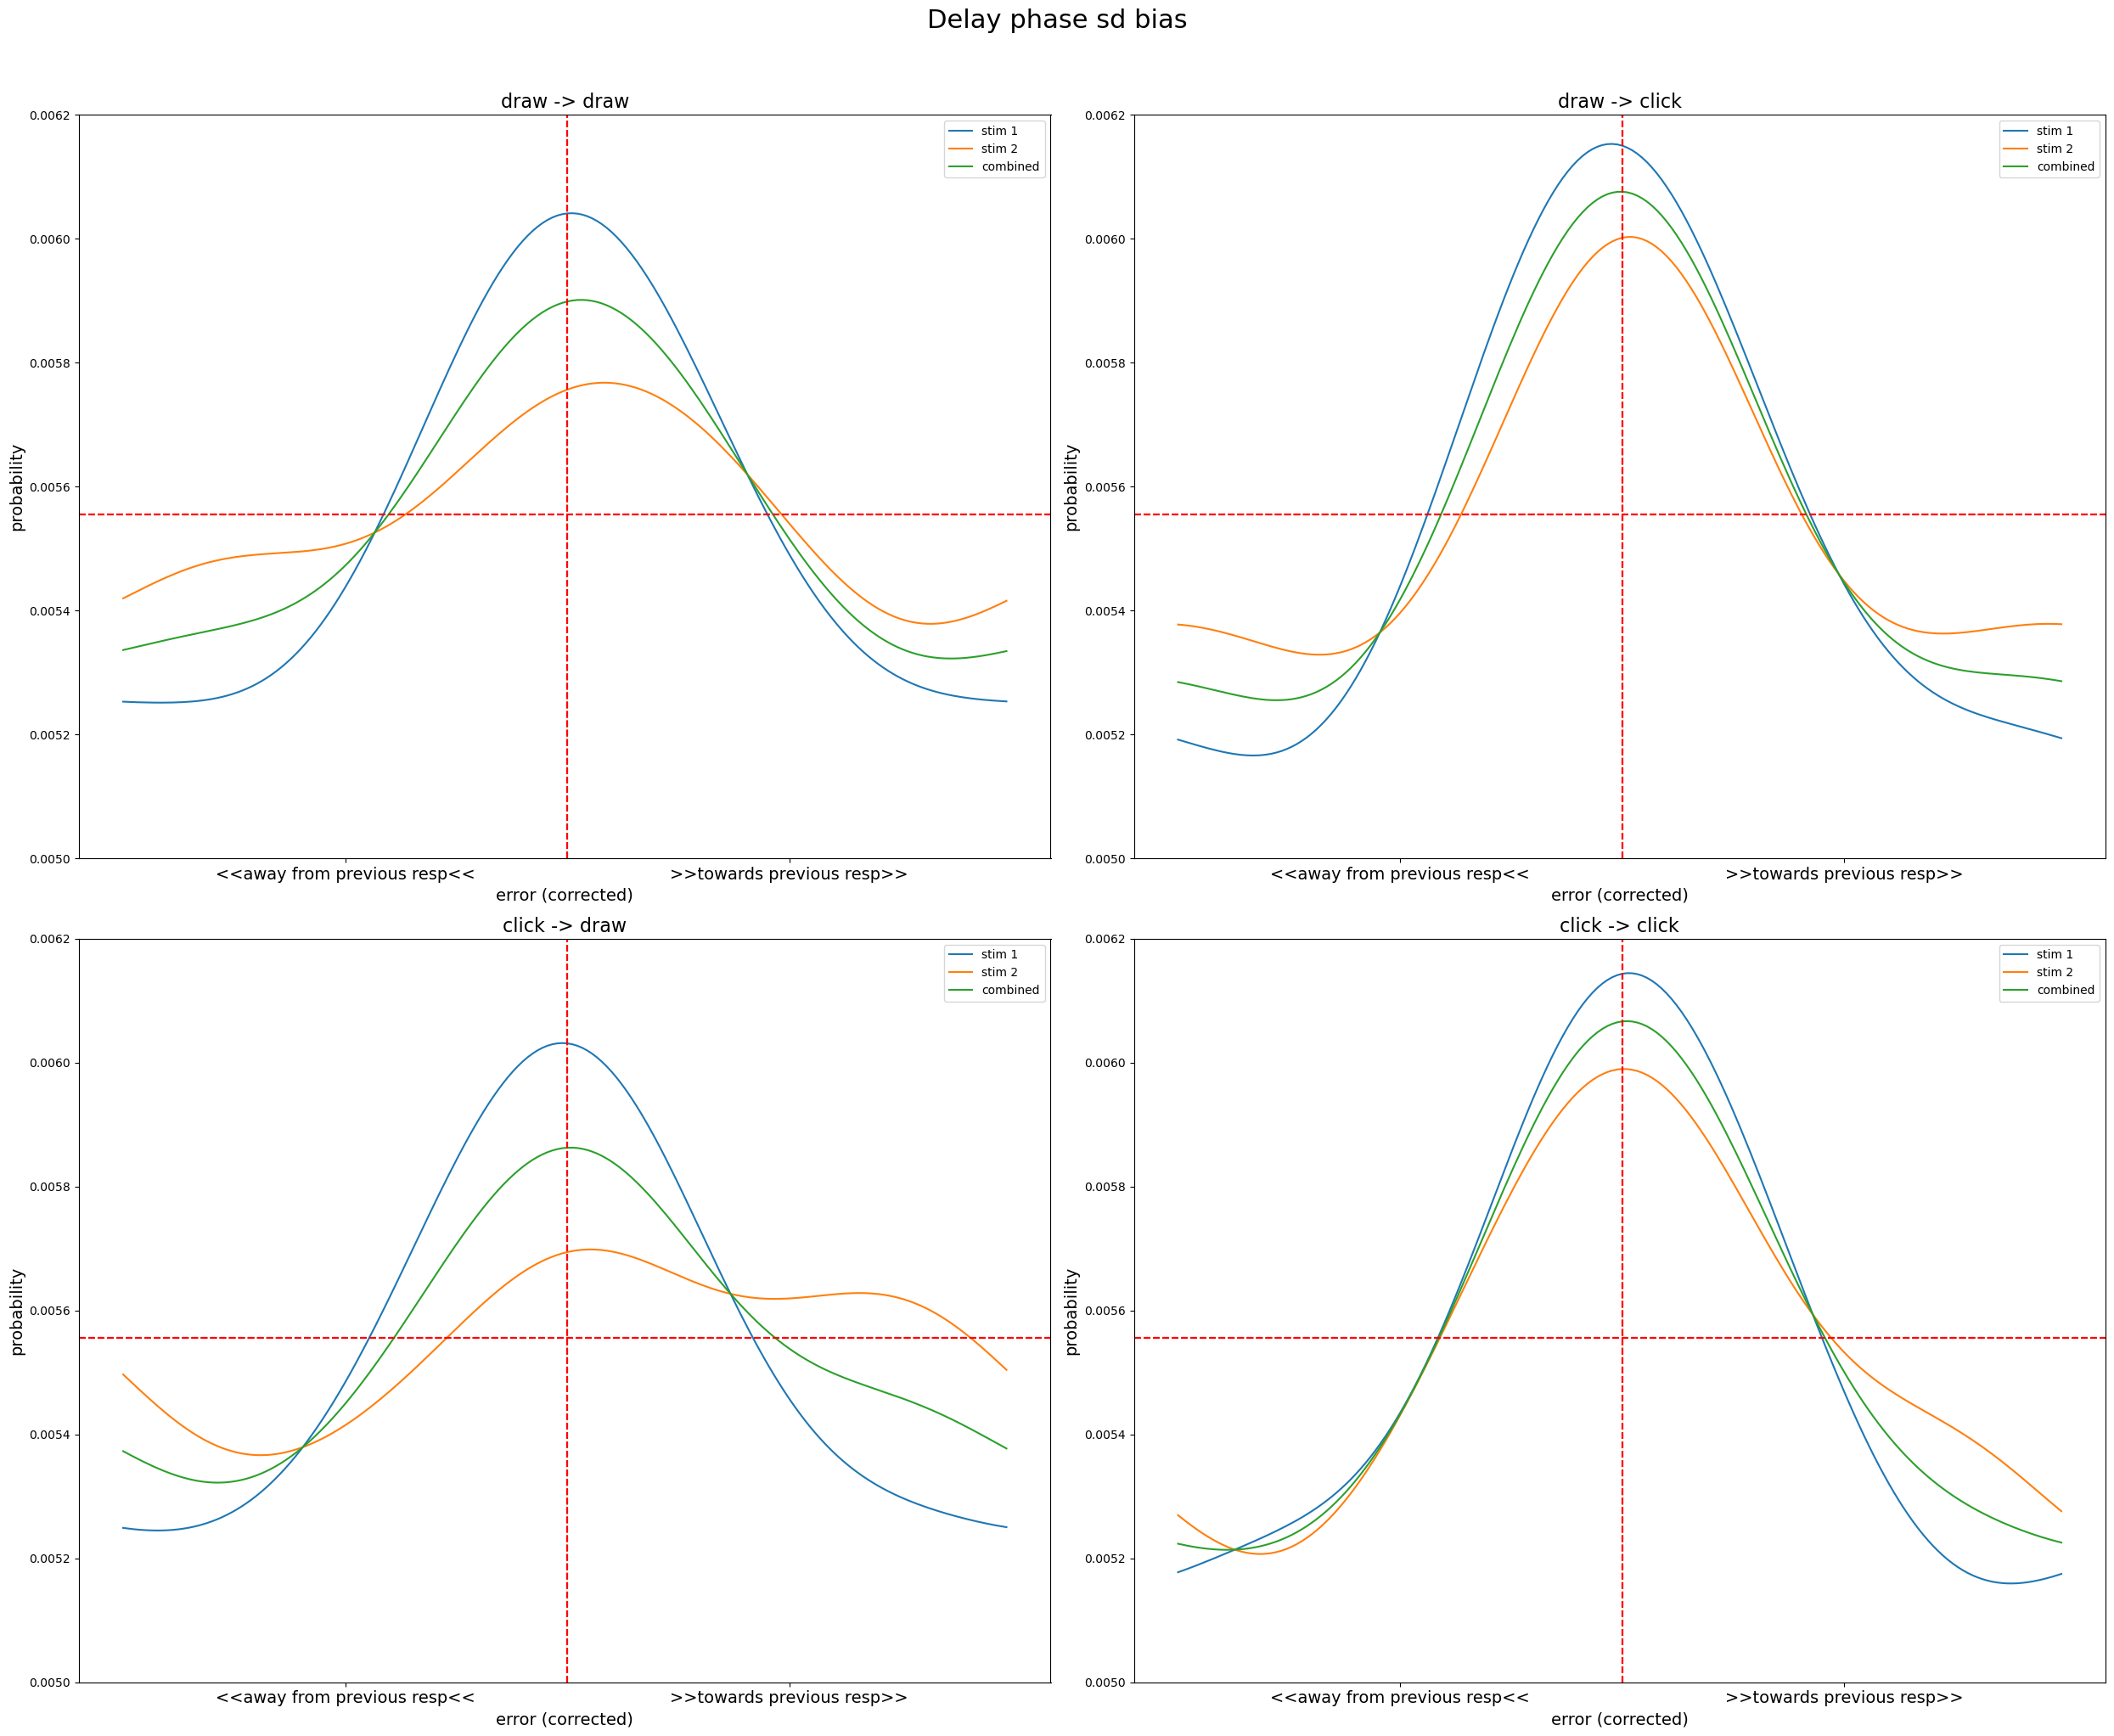

In [50]:
# also check serial bias
fig, axs = plt.subplots(2, 2, figsize=(25, 20))
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        ax = axs[i, j]
        results = all_delay_across_modes[(train_mode, test_mode)]
        display_stats_and_distrib(ax,
            results,
            stats_type='sd', 
            common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings)
        ax.set_title(f'{train_mode} -> {test_mode}', fontsize=16)

plt.suptitle('Delay phase sd bias', fontsize=22, y=1.02)
plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_cross_modes_sd.png')
plt.savefig(plot_path)

#### Comments
- clicking is easier to decode; drawing seems more complex
- there is an overall clockwise bias
- a very small, not-significant bias away from previous response


## Now further split the delay

#### create sliding windows throughout the delay